#### Import Libraries

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


#### Folder as a class: Tensorflow's image_dataset_from_directory 

In [30]:
# Define the path to the directory that contain the face dataset (adult & kid)
data_dir = 'dataset_binary'

# create a dataset using image_dataset_from_directory
batch_size = 32
image_size = (224, 224) # specify the desired image size

# get training dataset
train_dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    batch_size = batch_size,
    image_size = image_size,
    validation_split = 0.2,
    subset = 'training',
    seed=42,
)

# validation dataset
validation_dataset = image_dataset_from_directory(
    data_dir,
    shuffle=False, # Set shuffle to False for validation/test dataset
    batch_size = batch_size,
    image_size = image_size,
    validation_split = 0.2,
    subset='validation',
    seed=42,
)

# print class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 900 files belonging to 2 classes.
Using 720 files for training.
Found 900 files belonging to 2 classes.
Using 180 files for validation.
Class names: ['adult', 'kid']


#### Print some of the images to check

2024-04-30 10:36:42.267096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


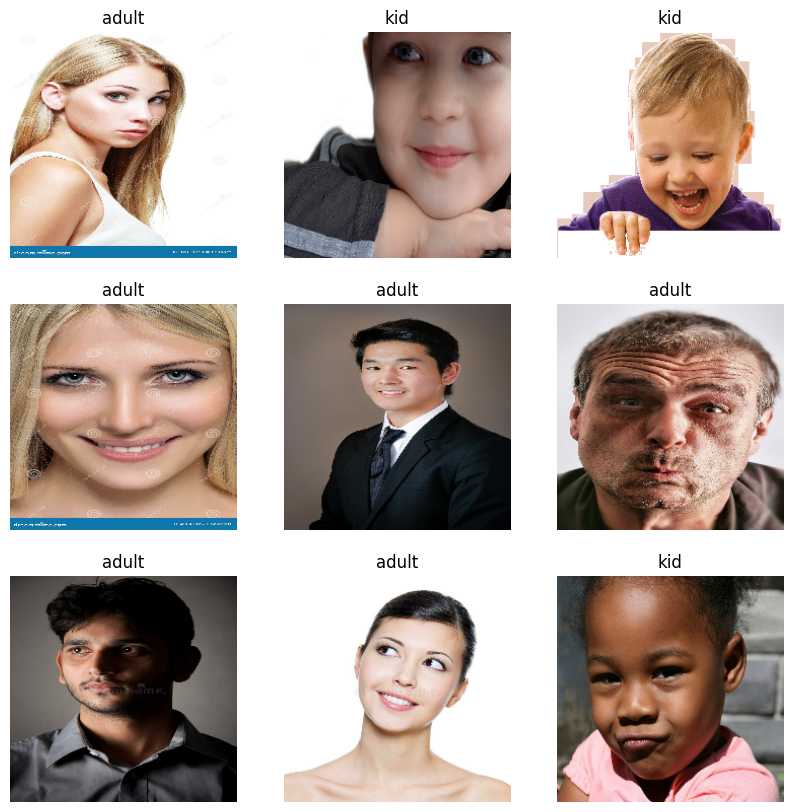

In [31]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): # 1 here means the first batch of images
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off") 

#### Preprocessing and Data Augmentation

In [32]:
# Using prefectch() prevents a memory bottleneck that can occur when reading from disk
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [33]:
def data_augmenter():
    data_augmentation = tf.keras.models.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

2024-04-30 10:36:45.253575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


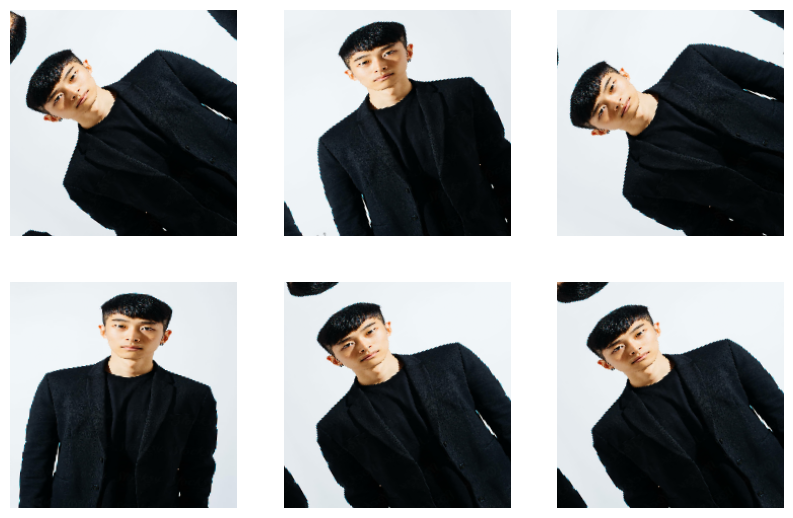

In [34]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    
    
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

#### Set-up the number of epochs

In [35]:
epoch_num = 50

#### Model 1: Modify the top layer

In [36]:
def top_only_model(image_shape=image_size, data_augmentation=data_augmenter()):    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
    
    x = tfl.Flatten()(x)
    # use a prediction layer with 3 neuron for multi-class classification
    #outputs = tfl.Dense(3, activation='softmax')(x)
    outputs = tfl.Dense(2, activation = 'softmax')(x)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

#### Compile the new model

In [37]:
top_only_model= top_only_model(image_size, data_augmentation)
base_learning_rate = 0.001
top_only_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Training the model

In [38]:
history = top_only_model.fit(train_dataset, validation_data=validation_dataset, epochs=epoch_num)

Epoch 1/50


2024-04-30 10:36:50.116648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 339ms/step - loss: 0.7024 - accuracy: 0.6139 - val_loss: 0.3119 - val_accuracy: 0.8500
Epoch 2/50


2024-04-30 10:37:00.026553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 315ms/step - loss: 0.4641 - accuracy: 0.7917 - val_loss: 0.3796 - val_accuracy: 0.7889
Epoch 3/50


2024-04-30 10:37:09.335750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 312ms/step - loss: 0.4208 - accuracy: 0.7972 - val_loss: 0.3040 - val_accuracy: 0.8278
Epoch 4/50


2024-04-30 10:37:18.603597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 317ms/step - loss: 0.3884 - accuracy: 0.8139 - val_loss: 0.3579 - val_accuracy: 0.7944
Epoch 5/50


2024-04-30 10:37:27.977145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 315ms/step - loss: 0.3570 - accuracy: 0.8361 - val_loss: 0.2134 - val_accuracy: 0.8889
Epoch 6/50


2024-04-30 10:37:37.258537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.3358 - accuracy: 0.8486 - val_loss: 0.1974 - val_accuracy: 0.9000
Epoch 7/50


2024-04-30 10:37:46.527369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 322ms/step - loss: 0.3367 - accuracy: 0.8500 - val_loss: 0.2787 - val_accuracy: 0.8556
Epoch 8/50


2024-04-30 10:37:56.022067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 314ms/step - loss: 0.3298 - accuracy: 0.8403 - val_loss: 0.3168 - val_accuracy: 0.8333
Epoch 9/50


2024-04-30 10:38:05.287094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 318ms/step - loss: 0.3250 - accuracy: 0.8556 - val_loss: 0.2200 - val_accuracy: 0.9000
Epoch 10/50


2024-04-30 10:38:14.703701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.3353 - accuracy: 0.8486 - val_loss: 0.2250 - val_accuracy: 0.8722
Epoch 11/50


2024-04-30 10:38:23.962545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 315ms/step - loss: 0.2826 - accuracy: 0.8861 - val_loss: 0.1928 - val_accuracy: 0.9111
Epoch 12/50


2024-04-30 10:38:33.282268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2928 - accuracy: 0.8708 - val_loss: 0.1870 - val_accuracy: 0.9222
Epoch 13/50


2024-04-30 10:38:42.543861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 312ms/step - loss: 0.2782 - accuracy: 0.8806 - val_loss: 0.3448 - val_accuracy: 0.8056
Epoch 14/50


2024-04-30 10:38:51.793148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 314ms/step - loss: 0.2542 - accuracy: 0.8903 - val_loss: 0.1676 - val_accuracy: 0.9444
Epoch 15/50


2024-04-30 10:39:01.076280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 308ms/step - loss: 0.2833 - accuracy: 0.8750 - val_loss: 0.1928 - val_accuracy: 0.9111
Epoch 16/50


2024-04-30 10:39:10.240185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 307ms/step - loss: 0.2612 - accuracy: 0.8875 - val_loss: 0.2418 - val_accuracy: 0.8833
Epoch 17/50


2024-04-30 10:39:19.410195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 316ms/step - loss: 0.2439 - accuracy: 0.8931 - val_loss: 0.2101 - val_accuracy: 0.9000
Epoch 18/50


2024-04-30 10:39:28.744068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 315ms/step - loss: 0.2469 - accuracy: 0.8764 - val_loss: 0.1879 - val_accuracy: 0.9222
Epoch 19/50


2024-04-30 10:39:38.041439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2400 - accuracy: 0.9056 - val_loss: 0.1073 - val_accuracy: 0.9611
Epoch 20/50


2024-04-30 10:39:47.318122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2686 - accuracy: 0.8861 - val_loss: 0.1171 - val_accuracy: 0.9556
Epoch 21/50


2024-04-30 10:39:56.590699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2618 - accuracy: 0.8819 - val_loss: 0.1431 - val_accuracy: 0.9500
Epoch 22/50


2024-04-30 10:40:05.847816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 318ms/step - loss: 0.2603 - accuracy: 0.9028 - val_loss: 0.1083 - val_accuracy: 0.9556
Epoch 23/50


2024-04-30 10:40:15.211159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 317ms/step - loss: 0.2440 - accuracy: 0.8958 - val_loss: 0.1746 - val_accuracy: 0.9333
Epoch 24/50


2024-04-30 10:40:24.584724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 309ms/step - loss: 0.2541 - accuracy: 0.8917 - val_loss: 0.2523 - val_accuracy: 0.9000
Epoch 25/50


2024-04-30 10:40:33.785938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 308ms/step - loss: 0.2278 - accuracy: 0.9042 - val_loss: 0.2811 - val_accuracy: 0.8667
Epoch 26/50


2024-04-30 10:40:42.946752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2244 - accuracy: 0.9069 - val_loss: 0.2664 - val_accuracy: 0.8722
Epoch 27/50


2024-04-30 10:40:52.202617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 317ms/step - loss: 0.2265 - accuracy: 0.9056 - val_loss: 0.1952 - val_accuracy: 0.9222
Epoch 28/50


2024-04-30 10:41:01.551173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 310ms/step - loss: 0.2204 - accuracy: 0.9097 - val_loss: 0.2254 - val_accuracy: 0.9000
Epoch 29/50


2024-04-30 10:41:10.750762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 312ms/step - loss: 0.2181 - accuracy: 0.9194 - val_loss: 0.1887 - val_accuracy: 0.9222
Epoch 30/50


2024-04-30 10:41:19.978562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 308ms/step - loss: 0.2434 - accuracy: 0.9014 - val_loss: 0.1858 - val_accuracy: 0.9222
Epoch 31/50


2024-04-30 10:41:29.138436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 314ms/step - loss: 0.2279 - accuracy: 0.9000 - val_loss: 0.1757 - val_accuracy: 0.9278
Epoch 32/50


2024-04-30 10:41:38.412750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 323ms/step - loss: 0.2027 - accuracy: 0.9208 - val_loss: 0.1430 - val_accuracy: 0.9389
Epoch 33/50


2024-04-30 10:41:47.911425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 319ms/step - loss: 0.2286 - accuracy: 0.9097 - val_loss: 0.2234 - val_accuracy: 0.9111
Epoch 34/50


2024-04-30 10:41:57.376089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2306 - accuracy: 0.9028 - val_loss: 0.1536 - val_accuracy: 0.9333
Epoch 35/50


2024-04-30 10:42:06.631945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 311ms/step - loss: 0.2463 - accuracy: 0.8861 - val_loss: 0.1350 - val_accuracy: 0.9389
Epoch 36/50


2024-04-30 10:42:15.859891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 317ms/step - loss: 0.2455 - accuracy: 0.8958 - val_loss: 0.2405 - val_accuracy: 0.9056
Epoch 37/50


2024-04-30 10:42:25.211588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 308ms/step - loss: 0.2140 - accuracy: 0.9167 - val_loss: 0.2708 - val_accuracy: 0.8778
Epoch 38/50


2024-04-30 10:42:34.340143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2033 - accuracy: 0.9111 - val_loss: 0.2772 - val_accuracy: 0.8722
Epoch 39/50


2024-04-30 10:42:43.593957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.1777 - accuracy: 0.9236 - val_loss: 0.2655 - val_accuracy: 0.8722
Epoch 40/50


2024-04-30 10:42:52.866046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 306ms/step - loss: 0.1954 - accuracy: 0.9181 - val_loss: 0.2603 - val_accuracy: 0.8778
Epoch 41/50


2024-04-30 10:43:01.987512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 311ms/step - loss: 0.2003 - accuracy: 0.9139 - val_loss: 0.2166 - val_accuracy: 0.9222
Epoch 42/50


2024-04-30 10:43:11.226057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 314ms/step - loss: 0.2137 - accuracy: 0.9097 - val_loss: 0.1669 - val_accuracy: 0.9333
Epoch 43/50


2024-04-30 10:43:20.519678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.2089 - accuracy: 0.9208 - val_loss: 0.1420 - val_accuracy: 0.9444
Epoch 44/50


2024-04-30 10:43:29.786828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 319ms/step - loss: 0.2115 - accuracy: 0.9097 - val_loss: 0.1859 - val_accuracy: 0.9222
Epoch 45/50


2024-04-30 10:43:39.227464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.1877 - accuracy: 0.9208 - val_loss: 0.1265 - val_accuracy: 0.9500
Epoch 46/50


2024-04-30 10:43:48.478549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 314ms/step - loss: 0.2409 - accuracy: 0.9056 - val_loss: 0.1661 - val_accuracy: 0.9333
Epoch 47/50


2024-04-30 10:43:57.765908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 314ms/step - loss: 0.1956 - accuracy: 0.9278 - val_loss: 0.1835 - val_accuracy: 0.9222
Epoch 48/50


2024-04-30 10:44:07.016422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.1969 - accuracy: 0.9097 - val_loss: 0.2263 - val_accuracy: 0.9111
Epoch 49/50


2024-04-30 10:44:16.293555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 313ms/step - loss: 0.1900 - accuracy: 0.9250 - val_loss: 0.1853 - val_accuracy: 0.9222
Epoch 50/50


2024-04-30 10:44:25.558631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 9s 310ms/step - loss: 0.2045 - accuracy: 0.9194 - val_loss: 0.2089 - val_accuracy: 0.9000


#### Plot the training and validation accuracy

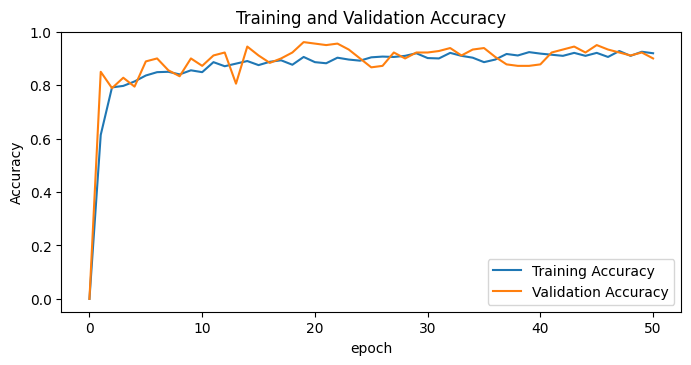

In [39]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('/trasnfer_learning_experiment/' + str(epoch_num) + '_transfer_binary_top_only.png')
plt.show()

In [40]:
name_top_only = str(epoch_num) + '_transfer_binary_top_only' +'.keras'
top_only_model.save('/transfer_learning_experiment/' + name_top_only)

#### Model 3: Retraining last ~30 layers

In [41]:
def top_30_model(image_shape=image_size, data_augmentation=data_augmenter()):    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = True 

        # fine tune from this layer onwards (re-train last 30 layers)
    fine_tune_at = 120

    # Freeze all the layers before the 'fine_tune_at' layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable=False


    # create the input layer (Same as the imageNetv2 input size)
    
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
    
    x = tfl.Flatten()(x)
    # use a prediction layer with 3 neuron for multi-class classification
    #outputs = tfl.Dense(3, activation='softmax')(x)
    outputs = tfl.Dense(2, activation = 'softmax')(x)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [42]:
top_30_model = top_30_model(image_size, data_augmentation)
# define the loss function 
loss_function = 'sparse_categorical_crossentropy'

# define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1*base_learning_rate)

# use accuracy as evaluation metric
metrics = ['accuracy']


top_30_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

#### Train the model

In [43]:
history = top_30_model.fit(train_dataset, validation_data=validation_dataset, epochs=epoch_num)

Epoch 1/50


2024-04-30 10:44:38.148757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 451ms/step - loss: 0.5871 - accuracy: 0.7194 - val_loss: 0.9303 - val_accuracy: 0.5278
Epoch 2/50


2024-04-30 10:44:50.740203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 369ms/step - loss: 0.4314 - accuracy: 0.8167 - val_loss: 0.1937 - val_accuracy: 0.9333
Epoch 3/50


2024-04-30 10:45:01.423186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 375ms/step - loss: 0.3251 - accuracy: 0.8639 - val_loss: 0.9677 - val_accuracy: 0.5222
Epoch 4/50


2024-04-30 10:45:12.219676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 370ms/step - loss: 0.3247 - accuracy: 0.8500 - val_loss: 0.0731 - val_accuracy: 0.9944
Epoch 5/50


2024-04-30 10:45:22.838435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 388ms/step - loss: 0.2541 - accuracy: 0.8847 - val_loss: 0.3426 - val_accuracy: 0.8444
Epoch 6/50


2024-04-30 10:45:33.863264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 379ms/step - loss: 0.1823 - accuracy: 0.9250 - val_loss: 0.1160 - val_accuracy: 0.9611
Epoch 7/50


2024-04-30 10:45:44.635770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 355ms/step - loss: 0.1454 - accuracy: 0.9403 - val_loss: 0.1232 - val_accuracy: 0.9444
Epoch 8/50


2024-04-30 10:45:54.889453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 362ms/step - loss: 0.1581 - accuracy: 0.9431 - val_loss: 0.0808 - val_accuracy: 0.9667
Epoch 9/50


2024-04-30 10:46:05.300506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 358ms/step - loss: 0.1725 - accuracy: 0.9292 - val_loss: 0.3896 - val_accuracy: 0.8167
Epoch 10/50


2024-04-30 10:46:15.643877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.0878 - accuracy: 0.9653 - val_loss: 0.0810 - val_accuracy: 0.9556
Epoch 11/50


2024-04-30 10:46:26.004683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 355ms/step - loss: 0.0688 - accuracy: 0.9750 - val_loss: 0.1684 - val_accuracy: 0.9389
Epoch 12/50


2024-04-30 10:46:36.230809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 360ms/step - loss: 0.0958 - accuracy: 0.9639 - val_loss: 0.3365 - val_accuracy: 0.8444
Epoch 13/50


2024-04-30 10:46:46.577500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.1233 - accuracy: 0.9472 - val_loss: 0.0640 - val_accuracy: 0.9722
Epoch 14/50


2024-04-30 10:46:56.915830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 361ms/step - loss: 0.0913 - accuracy: 0.9611 - val_loss: 0.2943 - val_accuracy: 0.9056
Epoch 15/50


2024-04-30 10:47:07.265658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 361ms/step - loss: 0.0773 - accuracy: 0.9708 - val_loss: 0.1317 - val_accuracy: 0.9500
Epoch 16/50


2024-04-30 10:47:17.620712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 358ms/step - loss: 0.0392 - accuracy: 0.9917 - val_loss: 0.1281 - val_accuracy: 0.9500
Epoch 17/50


2024-04-30 10:47:27.891212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 358ms/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 0.1788 - val_accuracy: 0.9167
Epoch 18/50


2024-04-30 10:47:38.217703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 358ms/step - loss: 0.0440 - accuracy: 0.9833 - val_loss: 0.2688 - val_accuracy: 0.9167
Epoch 19/50


2024-04-30 10:47:48.516488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 361ms/step - loss: 0.0551 - accuracy: 0.9764 - val_loss: 0.1212 - val_accuracy: 0.9556
Epoch 20/50


2024-04-30 10:47:58.869600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 353ms/step - loss: 0.0338 - accuracy: 0.9875 - val_loss: 0.0402 - val_accuracy: 0.9833
Epoch 21/50


2024-04-30 10:48:09.065106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 357ms/step - loss: 0.0789 - accuracy: 0.9667 - val_loss: 0.4061 - val_accuracy: 0.8889
Epoch 22/50


2024-04-30 10:48:19.311434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 356ms/step - loss: 0.0537 - accuracy: 0.9778 - val_loss: 0.2284 - val_accuracy: 0.9278
Epoch 23/50


2024-04-30 10:48:29.595270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 355ms/step - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.1918 - val_accuracy: 0.9556
Epoch 24/50


2024-04-30 10:48:39.854804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 358ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0648 - val_accuracy: 0.9889
Epoch 25/50


2024-04-30 10:48:50.142538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 356ms/step - loss: 0.0857 - accuracy: 0.9681 - val_loss: 0.0528 - val_accuracy: 0.9778
Epoch 26/50


2024-04-30 10:49:00.396157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 362ms/step - loss: 0.0463 - accuracy: 0.9875 - val_loss: 0.1302 - val_accuracy: 0.9611
Epoch 27/50


2024-04-30 10:49:10.794872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 363ms/step - loss: 0.0328 - accuracy: 0.9903 - val_loss: 0.0666 - val_accuracy: 0.9778
Epoch 28/50


2024-04-30 10:49:21.240771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 357ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1033 - val_accuracy: 0.9667
Epoch 29/50


2024-04-30 10:49:31.524824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 385ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9778
Epoch 30/50


2024-04-30 10:49:42.430766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 355ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 0.0825 - val_accuracy: 0.9722
Epoch 31/50


2024-04-30 10:49:52.722771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 360ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9778
Epoch 32/50


2024-04-30 10:50:03.083849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 362ms/step - loss: 0.0098 - accuracy: 0.9958 - val_loss: 0.0951 - val_accuracy: 0.9722
Epoch 33/50


2024-04-30 10:50:13.489395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 362ms/step - loss: 0.0206 - accuracy: 0.9917 - val_loss: 0.1318 - val_accuracy: 0.9722
Epoch 34/50


2024-04-30 10:50:23.909868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 0.0695 - val_accuracy: 0.9722
Epoch 35/50


2024-04-30 10:50:34.224411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 356ms/step - loss: 0.0299 - accuracy: 0.9889 - val_loss: 0.1406 - val_accuracy: 0.9556
Epoch 36/50


2024-04-30 10:50:44.546760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.0208 - accuracy: 0.9931 - val_loss: 0.1576 - val_accuracy: 0.9556
Epoch 37/50


2024-04-30 10:50:54.881714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.0785 - accuracy: 0.9681 - val_loss: 0.1495 - val_accuracy: 0.9611
Epoch 38/50


2024-04-30 10:51:05.211951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 362ms/step - loss: 0.0229 - accuracy: 0.9917 - val_loss: 0.2918 - val_accuracy: 0.9222
Epoch 39/50


2024-04-30 10:51:15.626503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 11s 368ms/step - loss: 0.0499 - accuracy: 0.9819 - val_loss: 0.2026 - val_accuracy: 0.9556
Epoch 40/50


2024-04-30 10:51:26.173021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 357ms/step - loss: 0.0493 - accuracy: 0.9861 - val_loss: 0.1054 - val_accuracy: 0.9667
Epoch 41/50


2024-04-30 10:51:36.473396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 358ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.2083 - val_accuracy: 0.9611
Epoch 42/50


2024-04-30 10:51:46.784422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 362ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1480 - val_accuracy: 0.9611
Epoch 43/50


2024-04-30 10:51:57.210477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.0155 - accuracy: 0.9972 - val_loss: 0.1283 - val_accuracy: 0.9611
Epoch 44/50


2024-04-30 10:52:07.527365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 361ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0293 - val_accuracy: 0.9889
Epoch 45/50


2024-04-30 10:52:17.870454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 360ms/step - loss: 0.0267 - accuracy: 0.9875 - val_loss: 0.2214 - val_accuracy: 0.9556
Epoch 46/50


2024-04-30 10:52:28.243439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 356ms/step - loss: 0.0286 - accuracy: 0.9903 - val_loss: 0.2557 - val_accuracy: 0.9111
Epoch 47/50


2024-04-30 10:52:38.514010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.0111 - accuracy: 0.9986 - val_loss: 0.0994 - val_accuracy: 0.9778
Epoch 48/50


2024-04-30 10:52:48.861335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 361ms/step - loss: 0.0070 - accuracy: 0.9986 - val_loss: 0.1015 - val_accuracy: 0.9778
Epoch 49/50


2024-04-30 10:52:59.225401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 360ms/step - loss: 0.0075 - accuracy: 0.9972 - val_loss: 0.0937 - val_accuracy: 0.9778
Epoch 50/50


2024-04-30 10:53:09.583378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 10s 359ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.9833


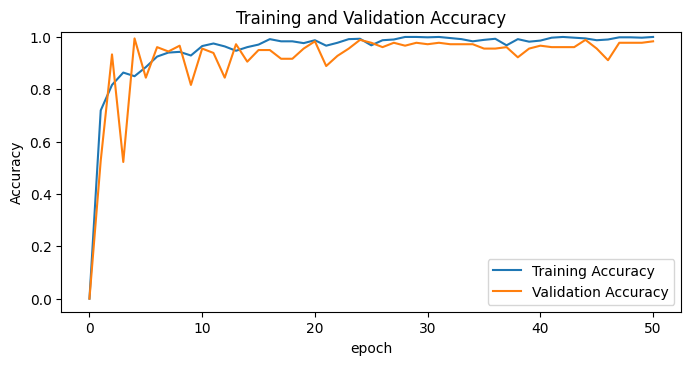

In [44]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.02])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('/trasnfer_learning_experiment/' + str(epoch_num) + '_transfer_binary_top_30.png')
plt.show()

In [45]:
# save as keras model
name_top30= str(epoch_num) + '_transfer_binary_top30' +'.keras'
top_30_model.save('/transfer_learning_experiment/' + name_top30)

#### Building my own model

In [46]:
# Import libraries
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout

In [47]:
# Create the model
my_model = models.Sequential()

# Convolutional layer 1
my_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
my_model.add(layers.MaxPooling2D((2, 2)))

my_model.add(Dropout(0.25))

# Convolutional layer 2
my_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
my_model.add(layers.MaxPooling2D((2, 2)))

my_model.add(Dropout(0.25))

# Convolutional layer 3
my_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
my_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for the fully connected layers
my_model.add(layers.Flatten())

# Fully connected layers
my_model.add(layers.Dense(128, activation='relu'))
my_model.add(Dropout(0.25))

my_model.add(layers.Dense(2, activation='softmax'))


# Compile the model
my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])



my_model_history = my_model.fit(train_dataset, epochs=epoch_num, validation_data=validation_dataset)

# Print the training history
print(my_model_history.history)

Epoch 1/50


2024-04-30 10:53:20.942268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 18s 641ms/step - loss: 604.4724 - accuracy: 0.5236 - val_loss: 0.6820 - val_accuracy: 0.8667
Epoch 2/50


2024-04-30 10:53:37.975954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 16s 584ms/step - loss: 0.6774 - accuracy: 0.5389 - val_loss: 0.6865 - val_accuracy: 0.9056
Epoch 3/50


2024-04-30 10:53:53.608711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 562ms/step - loss: 0.6564 - accuracy: 0.6153 - val_loss: 0.6824 - val_accuracy: 0.8667
Epoch 4/50


2024-04-30 10:54:08.725561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 554ms/step - loss: 0.6072 - accuracy: 0.6556 - val_loss: 0.6483 - val_accuracy: 0.8333
Epoch 5/50


2024-04-30 10:54:23.673550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 558ms/step - loss: 0.5571 - accuracy: 0.7056 - val_loss: 0.6282 - val_accuracy: 0.9000
Epoch 6/50


2024-04-30 10:54:38.648632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 558ms/step - loss: 0.4798 - accuracy: 0.7625 - val_loss: 0.5442 - val_accuracy: 0.8222
Epoch 7/50


2024-04-30 10:54:53.620220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 556ms/step - loss: 0.4646 - accuracy: 0.7694 - val_loss: 0.4822 - val_accuracy: 0.9278
Epoch 8/50


2024-04-30 10:55:08.599292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 559ms/step - loss: 0.4090 - accuracy: 0.8028 - val_loss: 0.4190 - val_accuracy: 0.9167
Epoch 9/50


2024-04-30 10:55:23.591009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 565ms/step - loss: 0.2907 - accuracy: 0.8736 - val_loss: 0.3559 - val_accuracy: 0.9389
Epoch 10/50


2024-04-30 10:55:39.050028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 551ms/step - loss: 0.2771 - accuracy: 0.8708 - val_loss: 0.3825 - val_accuracy: 0.9278
Epoch 11/50


2024-04-30 10:55:53.861215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 546ms/step - loss: 0.2816 - accuracy: 0.8917 - val_loss: 0.3033 - val_accuracy: 0.9444
Epoch 12/50


2024-04-30 10:56:08.590850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 549ms/step - loss: 0.2040 - accuracy: 0.9208 - val_loss: 0.3758 - val_accuracy: 0.9278
Epoch 13/50


2024-04-30 10:56:23.379661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 557ms/step - loss: 0.1935 - accuracy: 0.9153 - val_loss: 0.4249 - val_accuracy: 0.9389
Epoch 14/50


2024-04-30 10:56:38.374244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 571ms/step - loss: 0.1265 - accuracy: 0.9542 - val_loss: 0.4154 - val_accuracy: 0.9333
Epoch 15/50


2024-04-30 10:56:53.640135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 555ms/step - loss: 0.1725 - accuracy: 0.9403 - val_loss: 0.2998 - val_accuracy: 0.9500
Epoch 16/50


2024-04-30 10:57:08.550463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 567ms/step - loss: 0.1518 - accuracy: 0.9431 - val_loss: 0.3633 - val_accuracy: 0.9278
Epoch 17/50


2024-04-30 10:57:23.784863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 552ms/step - loss: 0.1166 - accuracy: 0.9556 - val_loss: 0.3267 - val_accuracy: 0.9278
Epoch 18/50


2024-04-30 10:57:38.669588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 552ms/step - loss: 0.1695 - accuracy: 0.9556 - val_loss: 0.4613 - val_accuracy: 0.9389
Epoch 19/50


2024-04-30 10:57:53.569585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 549ms/step - loss: 0.1246 - accuracy: 0.9542 - val_loss: 0.4637 - val_accuracy: 0.9333
Epoch 20/50


2024-04-30 10:58:08.396611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 556ms/step - loss: 0.0680 - accuracy: 0.9778 - val_loss: 0.5449 - val_accuracy: 0.9167
Epoch 21/50


2024-04-30 10:58:23.373831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 556ms/step - loss: 0.0806 - accuracy: 0.9750 - val_loss: 0.6111 - val_accuracy: 0.9111
Epoch 22/50


2024-04-30 10:58:38.356853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 554ms/step - loss: 0.0739 - accuracy: 0.9778 - val_loss: 0.6093 - val_accuracy: 0.9111
Epoch 23/50


2024-04-30 10:58:53.327659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 550ms/step - loss: 0.1161 - accuracy: 0.9653 - val_loss: 0.6353 - val_accuracy: 0.8944
Epoch 24/50


2024-04-30 10:59:08.136630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 552ms/step - loss: 0.0487 - accuracy: 0.9792 - val_loss: 0.5801 - val_accuracy: 0.9111
Epoch 25/50


2024-04-30 10:59:22.964387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 548ms/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 0.7144 - val_accuracy: 0.8944
Epoch 26/50


2024-04-30 10:59:37.691259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 548ms/step - loss: 0.0803 - accuracy: 0.9792 - val_loss: 0.4934 - val_accuracy: 0.9000
Epoch 27/50


2024-04-30 10:59:52.447710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 549ms/step - loss: 0.1389 - accuracy: 0.9708 - val_loss: 0.9177 - val_accuracy: 0.8889
Epoch 28/50


2024-04-30 11:00:07.204994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 546ms/step - loss: 0.0638 - accuracy: 0.9708 - val_loss: 0.9764 - val_accuracy: 0.8889
Epoch 29/50


2024-04-30 11:00:21.923365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 546ms/step - loss: 0.0726 - accuracy: 0.9833 - val_loss: 0.4680 - val_accuracy: 0.9111
Epoch 30/50


2024-04-30 11:00:36.617044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 565ms/step - loss: 0.0735 - accuracy: 0.9792 - val_loss: 0.7193 - val_accuracy: 0.8944
Epoch 31/50


2024-04-30 11:00:51.918480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 550ms/step - loss: 0.0469 - accuracy: 0.9806 - val_loss: 0.5239 - val_accuracy: 0.9222
Epoch 32/50


2024-04-30 11:01:06.756830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 555ms/step - loss: 0.0265 - accuracy: 0.9861 - val_loss: 0.5420 - val_accuracy: 0.9222
Epoch 33/50


2024-04-30 11:01:21.677064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 550ms/step - loss: 0.0806 - accuracy: 0.9708 - val_loss: 0.8600 - val_accuracy: 0.8944
Epoch 34/50


2024-04-30 11:01:36.598271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 552ms/step - loss: 0.0355 - accuracy: 0.9944 - val_loss: 0.3410 - val_accuracy: 0.9389
Epoch 35/50


2024-04-30 11:01:51.508567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 558ms/step - loss: 0.0358 - accuracy: 0.9847 - val_loss: 0.6586 - val_accuracy: 0.9111
Epoch 36/50


2024-04-30 11:02:06.495130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 554ms/step - loss: 0.0194 - accuracy: 0.9944 - val_loss: 0.7016 - val_accuracy: 0.9111
Epoch 37/50


2024-04-30 11:02:21.405329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 553ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.6712 - val_accuracy: 0.9111
Epoch 38/50


2024-04-30 11:02:36.311240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 555ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.6716 - val_accuracy: 0.9167
Epoch 39/50


2024-04-30 11:02:51.280396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 558ms/step - loss: 0.0353 - accuracy: 0.9917 - val_loss: 0.6509 - val_accuracy: 0.9222
Epoch 40/50


2024-04-30 11:03:06.257654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 546ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.8000 - val_accuracy: 0.9056
Epoch 41/50


2024-04-30 11:03:21.035280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 549ms/step - loss: 0.0522 - accuracy: 0.9875 - val_loss: 1.1326 - val_accuracy: 0.8833
Epoch 42/50


2024-04-30 11:03:35.801735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 551ms/step - loss: 0.0771 - accuracy: 0.9847 - val_loss: 0.4013 - val_accuracy: 0.9500
Epoch 43/50


2024-04-30 11:03:50.663032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 551ms/step - loss: 0.0416 - accuracy: 0.9806 - val_loss: 0.8179 - val_accuracy: 0.9056
Epoch 44/50


2024-04-30 11:04:05.481201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 552ms/step - loss: 0.0308 - accuracy: 0.9903 - val_loss: 0.8148 - val_accuracy: 0.9111
Epoch 45/50


2024-04-30 11:04:20.334567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 556ms/step - loss: 0.0106 - accuracy: 0.9944 - val_loss: 0.9124 - val_accuracy: 0.9111
Epoch 46/50


2024-04-30 11:04:35.306401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 557ms/step - loss: 0.0047 - accuracy: 0.9972 - val_loss: 1.0324 - val_accuracy: 0.9111
Epoch 47/50


2024-04-30 11:04:50.371958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 553ms/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 0.9386 - val_accuracy: 0.9056
Epoch 48/50


2024-04-30 11:05:05.274409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 551ms/step - loss: 0.0143 - accuracy: 0.9972 - val_loss: 0.5731 - val_accuracy: 0.9222
Epoch 49/50


2024-04-30 11:05:20.101149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 545ms/step - loss: 0.0049 - accuracy: 0.9972 - val_loss: 0.9084 - val_accuracy: 0.9111
Epoch 50/50


2024-04-30 11:05:34.816841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - 15s 549ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 0.5230 - val_accuracy: 0.9389
{'loss': [604.472412109375, 0.6774408221244812, 0.6563940048217773, 0.607174813747406, 0.5571250915527344, 0.4797670245170593, 0.46455904841423035, 0.4089679419994354, 0.2906511127948761, 0.27707692980766296, 0.2815735638141632, 0.20401941239833832, 0.1935466080904007, 0.12652373313903809, 0.17249958217144012, 0.15178713202476501, 0.11657959967851639, 0.16950340569019318, 0.12459910660982132, 0.06798013299703598, 0.08062946796417236, 0.07385628670454025, 0.11605847626924515, 0.04874587431550026, 0.04834172502160072, 0.0803438276052475, 0.1388571411371231, 0.0637902244925499, 0.07263146340847015, 0.07354053854942322, 0.046875614672899246, 0.0264524407684803, 0.08055251091718674, 0.03546097129583359, 0.035813551396131516, 0.019437747076153755, 0.016545213758945465, 0.01408967562019825, 0.035345032811164856, 0.018366044387221336, 0.05216824635863304, 0.077088

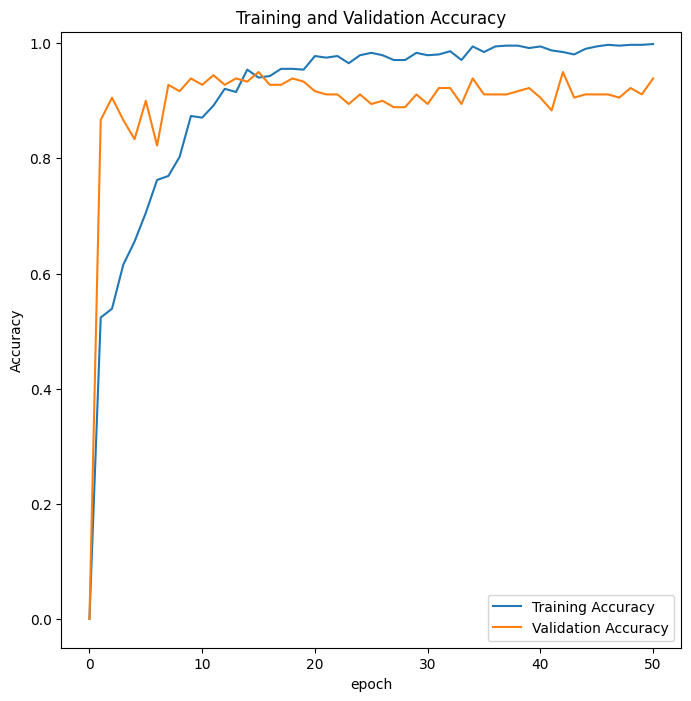

In [48]:
acc = [0.] + my_model_history.history['accuracy']
val_acc = [0.] + my_model_history.history['val_accuracy']


plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.02])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('/trasnfer_learning_experiment/' + str(epoch_num) + '_transfer_binary_custom.png')
plt.show()

In [49]:
# save as keras model
name_custom = str(epoch_num) + '_transfer_binary_custom' +'.keras'
my_model.save('/transfer_learning_experiment/' + name_custom)